### Načteme potřebné knihovny

In [31]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

### a) Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

In [32]:
# Načteme data do pandas dataframe
df = pd.read_excel('Projekt-2_Data.xlsx', nrows=100)

# Uložíme pouze sloupec s hodnotami z první úlohy
uloha_1_column = df['uloha_1 a)']

# Zobrazíme hodnoty 
uloha_1_column

0     2
1     2
2     1
3     3
4     0
     ..
95    3
96    0
97    3
98    1
99    1
Name: uloha_1 a), Length: 100, dtype: int64

### Kód pro úlohu 1a) 1+3

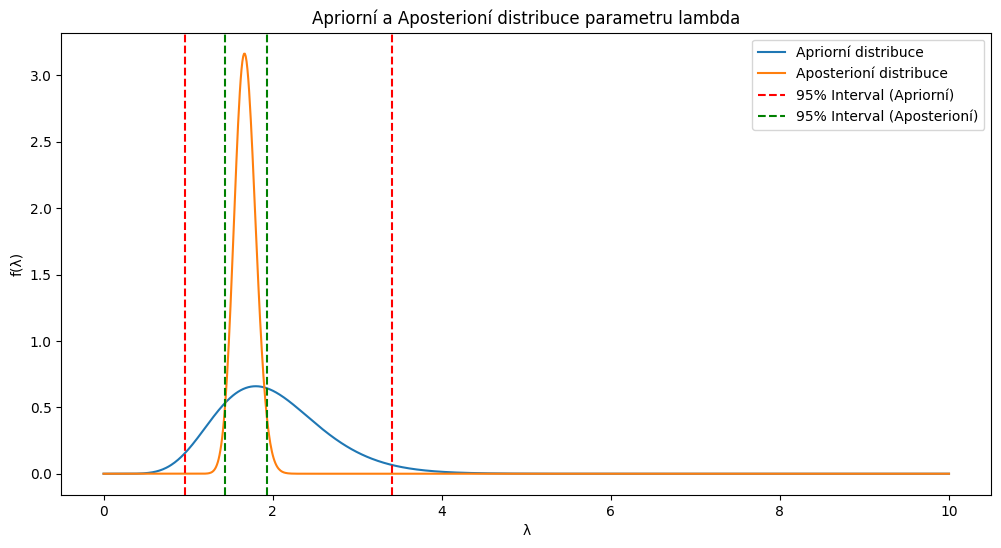

In [33]:
# Poissonovo rozdělení Alpha výskytů v Beta intervalech podle https://en.wikipedia.org/wiki/Conjugate_prior
alpha_prior = 10

beta_prior = 5

# Poisson -> Gamma rozdělení
prior_distribution = stats.gamma(alpha_prior, scale=1/beta_prior)


# Bayesovský výpočet - Aposterioní distribuce
alpha_posterior = alpha_prior + uloha_1_column.sum() # a' = a + sum(x_i)
beta_posterior = beta_prior + len(uloha_1_column) # b' = b + n  | n = počet pozorování
posterior_distribution = stats.gamma(alpha_posterior, scale=1/beta_posterior)

# Výpočet kvantilů pro interval spolehlivosti 
# VÝPOČET HODNOT PRO ÚKOL 3
lower_bound_prior, upper_bound_prior = stats.gamma.interval(0.95, alpha_prior, scale=1/beta_prior)
lower_bound_posterior, upper_bound_posterior = stats.gamma.interval(0.95, alpha_posterior, scale=1/beta_posterior)


# Vykreslení výsledků
x_values = np.linspace(0, 10, 1000)

# Apriorní a aposteriorní distribuce parametru lambda
plt.figure(figsize=(12, 6))
plt.plot(x_values, prior_distribution.pdf(x_values), label='Apriorní distribuce')
plt.plot(x_values, posterior_distribution.pdf(x_values), label='Aposterioní distribuce')
plt.axvline(lower_bound_prior, linestyle='--', color='red', label='95% Interval (Apriorní)')
plt.axvline(upper_bound_prior, linestyle='--', color='red')
plt.axvline(lower_bound_posterior, linestyle='--', color='green', label='95% Interval (Aposterioní)')
plt.axvline(upper_bound_posterior, linestyle='--', color='green')
plt.title('Apriorní a Aposterioní distribuce parametru lambda')
plt.xlabel('λ')
plt.ylabel('f(λ)')
plt.legend()
plt.show()


### Kód pro úlohu 1a) 2

5


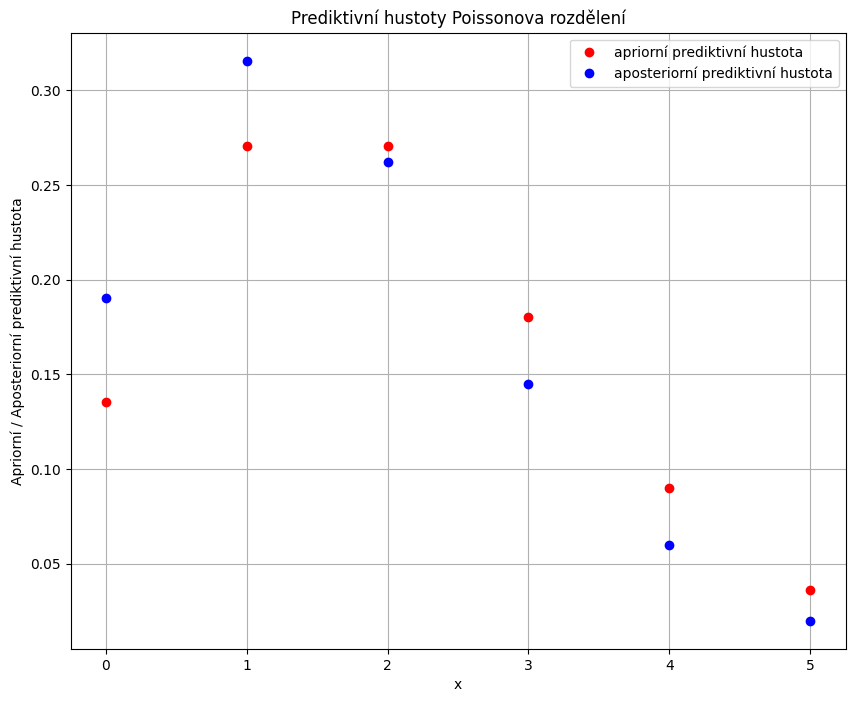

In [61]:
# Odhad připojení podle zadání 10 připojení za 5 ms
lambda_expert = 10 / 5

x_values = uloha_1_column.values

# Spočítáme apriorní prediktivní hustotu pro všechny možné hodnoty x
# funkce pmf zmíněna na wikipedii https://en.wikipedia.org/wiki/Conjugate_prior
x_range = np.arange(0, max(x_values) + 1)
apriori_pmf = stats.poisson.pmf(x_range, lambda_expert)

# Spočítáme aposteriori prediktivní hustotu pro všechny možné hodnoty x
lambda_observed = np.mean(x_values)
aposteriori_pmf = stats.poisson.pmf(x_range, lambda_observed)

# Hodnoty zobrazíme pomocí grafu
plt.figure(figsize=(10, 8))
plt.plot(x_range, apriori_pmf, 'o', label='apriorní prediktivní hustota', color='red')
plt.plot(x_range, aposteriori_pmf, 'o', label='aposteriorní prediktivní hustota', color='blue')
plt.xlabel('x')
plt.ylabel('Apriorní / Aposteriorní prediktivní hustota')
plt.title('Prediktivní hustoty Poissonova rozdělení')
plt.legend()
plt.grid(True)
plt.show()

### Kód pro úlohu 1a) 3 + 4 + 5

In [35]:
# Zobrazení výsledků intervalu spolehlivosti
print(f"95% Interval spolehlivosti (Apriorní): ({lower_bound_prior}, {upper_bound_prior})")
print(f"95% Interval spolehlivosti (Aposterioní): ({lower_bound_posterior}, {upper_bound_posterior})\n")

# Výběr dvou aposteriorních bodových odhadů parametru 𝜆
# Bodový odhad průměrné hodnoty, odpovídá střední hodnotě
# Jedná se o základní odhady, které nejlépe popisují data
mean_posterior = alpha_posterior / beta_posterior
# Bodoý odhad mediánu
median_posterior = (alpha_posterior - 1/3) / beta_posterior

print("Aposterioní bodové odhady parametru 𝜆:")
print(f"Střední hodnota: {mean_posterior}")
print(f"Medián: {median_posterior}")

# Bodové odhady počtu pozorovaní
# Opět se jedná o základní odhady, které nejlépe popisují data
# Apriorní bodový odhad průměrné hodnoty
mean_prior_observed = alpha_prior / beta_prior
# Aposterioní bodový odhad průměrné hodnoty
mean_posterior_observed = alpha_posterior / beta_posterior

print("\nApriorní a aposterioní bodové odhady počtu pozorovaní:")
print(f"Apriorní střední hodnota: {mean_prior_observed}")
print(f"Aposterioní střední hodnota: {mean_posterior_observed}")

95% Interval spolehlivosti (Apriorní): (0.9590777392264868, 3.416960690283833)
95% Interval spolehlivosti (Aposterioní): (1.4376938284869922, 1.9327207471868797)

Aposterioní bodové odhady parametru 𝜆:
Střední hodnota: 1.6761904761904762
Medián: 1.6730158730158728

Apriorní a aposterioní bodové odhady počtu pozorovaní:
Apriorní střední hodnota: 2.0
Aposterioní střední hodnota: 1.6761904761904762


### b) Aproximace diskrétním rozdělením

### Kód pro úlohu 1b) 1

### Věrohodnostní funkce

In [36]:
# Načteme data do pandas dataframe
df = pd.read_excel('Projekt-2_Data.xlsx')

# Hodnoty ze zadání
mean_value = 3 # 𝜇
std_value = 1 # 𝜎^2 
a_value = 1 # a

# Spočítáme kumulativní distribuční funkci podle odkazu 
# https://en.wikipedia.org/wiki/Truncated_normal_distribution
# Odpovídá jmenovateli ve vzorci f(x, 𝜇, 𝜎, a, b) = (1/𝜎) * ((normal distribution)/((cumulative distribution(b) - (cumulative distribution(a))))
def calculate_cdf(b, mean, std):
    return stats.norm.cdf(b, loc=mean, scale=std) - stats.norm.cdf(a_value, loc=mean, scale=std)
# Spočítáme standardní normální distribuci, opět podle odkazu # https://en.wikipedia.org/wiki/Truncated_normal_distribution
# Odpovídá čitateli ve vzorci f(x, 𝜇, 𝜎, a, b) = (1/𝜎) * ((normal distribution)/((cumulative distribution(b) - (cumulative distribution(a))))
def normal_dist(x , mean , sd):
    prob_density = (1/(np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

# V každé skupině (10 000 skupin) najdeme index řádku s nejvyšší hodnotou
max_indices = df.groupby('skupina')['uloha_1 b)_prior'].idxmax()


# Vytvoříme nový dataframe, který obsahuje pouze řádky s nejvyšší hodnotou
result_df = df.loc[max_indices]

# Rozdělíme námi zvolených 10 000 hodnot na 50 hodnot, neboli 50 různých parametrů 'b'
b = np.linspace(min(result_df["uloha_1 b)_prior"]), max(result_df["uloha_1 b)_prior"]), 50)

# Získáme data ze sloupce 'uloha_1 b)_pozorování' a ignorujeme NaN hodnoty
observed_data = df['uloha_1 b)_pozorování'].head(100)

# Filtrujeme hodnoty 'b' podle vzorce z odkazu https://en.wikipedia.org/wiki/Truncated_normal_distribution
# Výsledkem je seznam hodnot 'b', které jsou jsou větší, než všechny hodnoty pozorování
filtered_b = [value for value in b if all(a_value < i < value for i in observed_data)]

prob_density = []

# Projdeme námi zvolené hodnoty 'b' a vypočítáme pro každé z nich pravděpodobnostní hustotu
for value in filtered_b:
    # Spočítáme jmenovatel
    denominator = calculate_cdf(value, mean_value, std_value)
    # násobení 1/std_value je zbytečné, protože 1/1 = 1
    sum_prob = 1
    for i in observed_data:
        sum_prob *= (normal_dist(i, mean_value, std_value) / denominator)
    # Přidáme vypočítanou pravděpodobnostní hustotu do seznamu
    prob_density.append(sum_prob)
    
# Normujeme pravděpodobnostní hodnoty tak, aby jejich součet byl roven 1
sum_prob_density = sum(prob_density)
verohodnostni_funkce = [x / sum_prob_density for x in prob_density]

### Apriorní rozdělení

In [37]:
b = result_df["uloha_1 b)_prior"]

# Rozdělíme hodnoty 'b' do 50 intervalů a spočítáme jejich pravděpodobnostní hodnoty
probability_values, b = np.histogram(b, bins=50, density=True)

# Normujeme pravděpodobnostní hodnoty tak, aby jejich součet byl roven 1
bin_widths = np.diff(b)
apriorni_rozdeleni = probability_values * bin_widths
# Opět si do 'b' uložíme 50 hodnot
b = np.linspace(min(result_df["uloha_1 b)_prior"]), max(result_df["uloha_1 b)_prior"]), 50)

### Aposteriorní rozdělení

In [38]:
# Zvolíme pouze posledních 22 hodnot, jelikož věrohodnostní funkce obsahuje pouze posledních 22 hodnot 'b'
prior_probs = apriorni_rozdeleni[-22:]
# Věrohodnostní funkce zůstává stejná
density_probs = prob_density

# Reprezentujeme jako věrohodnostní funkci pro přehlednost vzorce
likelihood = density_probs

# Bayesova věta
numerator = likelihood * prior_probs
# Normujeme tak, aby součet byl roven 1
aposteriorni_rozdeleni  = numerator / np.sum(numerator)

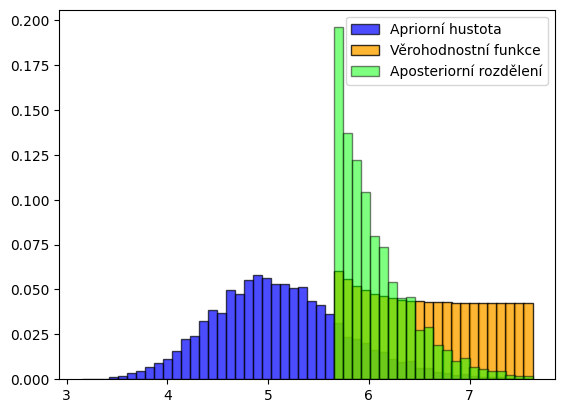

In [39]:
# Vykreslení výsledků
plt.bar(b, apriorni_rozdeleni, width=bin_widths, color='blue', alpha=0.7, label='Apriorní hustota', edgecolor='black')
plt.bar(filtered_b, verohodnostni_funkce, width=0.092, color='orange', alpha=0.8, label='Věrohodnostní funkce', edgecolor='black')
plt.bar(filtered_b, aposteriorni_rozdeleni, width=0.092, color='lime', alpha=0.5, label='Aposteriorní rozdělení', edgecolor='black')
plt.legend()
plt.show()

### Kód k úloze 1b) 2

In [40]:
# Spočítáme kumulativní distribuční funkci
cumulative_posterior = np.cumsum(aposteriorni_rozdeleni)

# Spočítáme spodní a horní hranici intervalu spolehlivosti
lower = np.argmax(cumulative_posterior >= 0.025)
upper = np.argmax(cumulative_posterior >= 0.975)

# Najdeme odpovídající hodnoty 'b'
lower_bound_posterior = filtered_b[lower]
upper_bound_posterior = filtered_b[upper]

print(f"95% interval spolehlivosti: ({lower_bound_posterior}, {upper_bound_posterior})")

95% interval spolehlivosti: (5.6999748786593525, 7.042014266583222)


In [41]:
# Spočítáme střední hodnotu a modus
# Středí hodnota se počítá jako součin věrohodnostní funkce a hodnot 'b'
expected_value = np.sum(aposteriorni_rozdeleni * filtered_b)

# Modus je hodnota 'b' s nejvyšší pravděpodobností
modus = np.argmax(aposteriorni_rozdeleni)
# Získáme hodnotu 'b' s nejvyšší pravděpodobností
map_value = filtered_b[modus]

print(f"Odhad střední hodnoty: {expected_value}")
print(f"Odhad modu: {map_value}")

Odhad střední hodnoty: 6.067086994212371
Odhad modu: 5.6999748786593525


### Úloha 2

### Kód k úloze 2) 1

In [42]:
# Načteme data pro 2. úlohu do pandas dataframe
data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='Úloha 2')

# Pro zjednodušení zápisu přejmenujeme sloupec 'Ping [ms]' na 'Ping'
data.rename(columns={'Ping [ms]': 'Ping'}, inplace=True)

# Převedeme kategorickou proměnnou na numerickou
data_encoded = pd.get_dummies(data, columns=['OSType'], drop_first=False, dtype=int)

# Spočítáme koeficienty korelace mezi jednotlivými sloupci
corr_matrix = data_encoded.corr().abs()
# Vybereme horní trojúhelníkovou matici, protože je symetrická
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Pokud mají některé sloupce korelaci větší než 0.7, tak je odstraníme
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]

# Odstraníme sloupce s korelací větší než 0.7
#data_encoded.drop(columns=to_drop, inplace=True)

# Zapíšeme plný model
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_MacOS + OSType_Windows + OSType_iOS + np.square(ActiveUsers) + ActiveUsers*InteractingPct + ActiveUsers*OSType_MacOS + ActiveUsers*OSType_Windows + ActiveUsers*OSType_iOS + np.square(InteractingPct) + InteractingPct * OSType_MacOS + InteractingPct * OSType_iOS + InteractingPct * OSType_Windows"

# Vytvoření modelu pro rovnici
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        23:01:05   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.3388      2.354     -0.144      0.886      -4.965       4.287
ActiveUsers                       0.0100      0.001     17.571      0.000       0.009       0.011
InteractingPct                   37.6062      4.567      8.234      0.000      28.633      46.580
OSType_MacOS                      2.0017      2.260      0.886      0.376      -2.440       6.443
OSType_Windows                    7.8174      2.217      3.526      0.000       3.461      12.174
OSType_iOS                       -0.0483      2.265     -0.021      0.983      -4.499       4.403
np.square(ActiveUsers)         -4.17e-07    4.4e-08     -9.469      0.000   -5.03e-07    -3.3e-07
ActiveUsers:InteractingPct       -0.0031      0.000     -8.532      0.000      -0.004      -0.002
ActiveUsers:OSType_MacOS          0.0014      0.000      4.536      0.000       0.001       0.002
ActiveUsers:OSType_Windows       -0.0008      0.000     -2.505      0.013      -0.001      -0.000
ActiveUsers:OSType_iOS           -0.0011      0.000     -3.369      0.001      -0.002      -0.000
np.square(InteractingPct)        -3.7258      3.492     -1.067      0.287     -10.587       3.135
InteractingPct:OSType_MacOS      -0.3566      2.530     -0.141      0.888      -5.327       4.614
InteractingPct:OSType_iOS         0.2678      2.691      0.100      0.921      -5.020       5.556
InteractingPct:OSType_Windows     0.4260      2.721      0.157      0.876      -4.919       5.771
==============================================================================
Omnibus:                      228.442   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3152.488
Skew:                           1.603   Prob(JB):                         0.00
Kurtosis:                      14.851   Cond. No.                     1.06e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# Zjistíme, které položka má nejvyšší p-hodnotu
summary_table = model.summary().tables[1]
p_values = summary_table.data[1:]

# Převedeme p-hodnoty na float a získáme index nejvyšší hodnoty
max_p_value_index = np.argmax([float(row[4]) for row in p_values])

# Získáme název proměnné a její p-hodnotu
max_p_variable = p_values[max_p_value_index][0]
max_p_value = float(p_values[max_p_value_index][4])

# Zobrazíme výsledky
print(f"The variable with the highest p-value is '{max_p_variable}' with P>|t| = {max_p_value}")

The variable with the highest p-value is 'OSType_iOS' with P>|t| = 0.983


In [44]:
# Pro další analýzu odstraníme proměnnou s nejvyšší p-hodnotou
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_MacOS + OSType_Windows + np.square(ActiveUsers) + ActiveUsers*InteractingPct + ActiveUsers*OSType_MacOS + ActiveUsers*OSType_Windows + np.square(InteractingPct) + InteractingPct * OSType_MacOS + InteractingPct * OSType_Windows"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     207.2
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          2.50e-176
Time:                        23:01:05   Log-Likelihood:                -1629.7
No. Observations:                 502   AIC:                             3283.
Df Residuals:                     490   BIC:                             3334.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.7098      1.904     -0.373      0.709      -4.450       3.031
ActiveUsers                       0.0095      0.001     17.168      0.000       0.008       0.011
InteractingPct                   37.6383      4.410      8.534      0.000      28.973      46.304
OSType_MacOS                      2.6643      1.976      1.348      0.178      -1.219       6.547
OSType_Windows                    8.4508      1.920      4.402      0.000       4.679      12.223
np.square(ActiveUsers)         -4.16e-07   4.65e-08     -8.954      0.000   -5.07e-07   -3.25e-07
ActiveUsers:InteractingPct       -0.0030      0.000     -7.895      0.000      -0.004      -0.002
ActiveUsers:OSType_MacOS          0.0018      0.000      6.783      0.000       0.001       0.002
ActiveUsers:OSType_Windows       -0.0003      0.000     -1.189      0.235      -0.001       0.000
np.square(InteractingPct)        -3.6170      3.689     -0.980      0.327     -10.866       3.632
InteractingPct:OSType_MacOS      -0.9809      2.215     -0.443      0.658      -5.332       3.371
InteractingPct:OSType_Windows    -0.1942      2.454     -0.079      0.937      -5.015       4.627
==============================================================================
Omnibus:                      181.124   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1868.555
Skew:                           1.261   Prob(JB):                         0.00
Kurtosis:                      12.109   Cond. No.                     9.26e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.26e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# Dále odstraníme proměnnou s nejvyšší p-hodnotou
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_MacOS + OSType_Windows + np.square(ActiveUsers) + ActiveUsers*InteractingPct + ActiveUsers*OSType_MacOS + ActiveUsers*OSType_Windows + np.square(InteractingPct) + InteractingPct * OSType_MacOS"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     228.4
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.62e-177
Time:                        23:01:05   Log-Likelihood:                -1629.7
No. Observations:                 502   AIC:                             3281.
Df Residuals:                     491   BIC:                             3328.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.6808      1.866     -0.365      0.715      -4.348       2.986
ActiveUsers                     0.0095      0.001     17.187      0.000       0.008       0.011
InteractingPct                 37.5710      4.323      8.691      0.000      29.077      46.065
OSType_MacOS                    2.6361      1.942      1.357      0.175      -1.179       6.451
OSType_Windows                  8.3681      1.609      5.201      0.000       5.207      11.529
np.square(ActiveUsers)      -4.161e-07   4.64e-08     -8.965      0.000   -5.07e-07   -3.25e-07
ActiveUsers:InteractingPct     -0.0030      0.000     -7.903      0.000      -0.004      -0.002
ActiveUsers:OSType_MacOS        0.0018      0.000      6.789      0.000       0.001       0.002
ActiveUsers:OSType_Windows     -0.0003      0.000     -1.201      0.230      -0.001       0.000
np.square(InteractingPct)      -3.6169      3.685     -0.981      0.327     -10.858       3.624
InteractingPct:OSType_MacOS    -0.9169      2.060     -0.445      0.656      -4.964       3.130
==============================================================================
Omnibus:                      181.097   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1868.443
Skew:                           1.261   Prob(JB):                         0.00
Kurtosis:                      12.109   Cond. No.                     9.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# Stále odstraňujeme proměnné s nejvyšší p-hodnotou
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_MacOS + OSType_Windows + np.square(ActiveUsers) + ActiveUsers*InteractingPct + ActiveUsers*OSType_MacOS + ActiveUsers*OSType_Windows + np.square(InteractingPct)"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     254.1
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.09e-178
Time:                        23:01:05   Log-Likelihood:                -1629.8
No. Observations:                 502   AIC:                             3280.
Df Residuals:                     492   BIC:                             3322.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.5639      1.846     -0.305      0.760      -4.191       3.064
ActiveUsers                    0.0095      0.001     17.209      0.000       0.008       0.011
InteractingPct                37.3293      4.285      8.711      0.000      28.910      45.749
OSType_MacOS                   2.1704      1.635      1.328      0.185      -1.041       5.382
OSType_Windows                 8.3594      1.608      5.200      0.000       5.201      11.518
np.square(ActiveUsers)     -4.164e-07   4.64e-08     -8.980      0.000   -5.08e-07   -3.25e-07
ActiveUsers:InteractingPct    -0.0030      0.000     -7.905      0.000      -0.004      -0.002
ActiveUsers:OSType_MacOS       0.0018      0.000      6.793      0.000       0.001       0.002
ActiveUsers:OSType_Windows    -0.0003      0.000     -1.194      0.233      -0.001       0.000
np.square(InteractingPct)     -3.6743      3.680     -0.998      0.319     -10.905       3.556
==============================================================================
Omnibus:                      182.667   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1916.661
Skew:                           1.270   Prob(JB):                         0.00
Kurtosis:                      12.230   Cond. No.                     9.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# Odstraníme další proměnnou s nejvyšší p-hodnotou
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_MacOS + OSType_Windows + np.square(ActiveUsers) + ActiveUsers*InteractingPct + ActiveUsers*OSType_MacOS + ActiveUsers*OSType_Windows"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     285.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.02e-179
Time:                        23:01:05   Log-Likelihood:                -1630.3
No. Observations:                 502   AIC:                             3279.
Df Residuals:                     493   BIC:                             3317.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0162      1.752      0.009      0.993      -3.427       3.459
ActiveUsers                    0.0095      0.001     17.203      0.000       0.008       0.011
InteractingPct                33.6905      2.254     14.947      0.000      29.262      38.119
OSType_MacOS                   2.0925      1.633      1.282      0.201      -1.116       5.301
OSType_Windows                 8.3762      1.607      5.211      0.000       5.218      11.534
np.square(ActiveUsers)     -4.158e-07   4.64e-08     -8.967      0.000   -5.07e-07   -3.25e-07
ActiveUsers:InteractingPct    -0.0030      0.000     -7.909      0.000      -0.004      -0.002
ActiveUsers:OSType_MacOS       0.0018      0.000      6.818      0.000       0.001       0.002
ActiveUsers:OSType_Windows    -0.0003      0.000     -1.172      0.242      -0.001       0.000
==============================================================================
Omnibus:                      183.823   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1955.577
Skew:                           1.276   Prob(JB):                         0.00
Kurtosis:                      12.327   Cond. No.                     4.22e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
# Odstraníme další proměnnou s nejvyšší p-hodnotou
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_MacOS + OSType_Windows + np.square(ActiveUsers) + ActiveUsers*InteractingPct + ActiveUsers*OSType_MacOS"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     326.2
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.09e-180
Time:                        23:01:05   Log-Likelihood:                -1631.0
No. Observations:                 502   AIC:                             3278.
Df Residuals:                     494   BIC:                             3312.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.6074      1.679      0.362      0.718      -2.691       3.906
ActiveUsers                    0.0094      0.001     17.211      0.000       0.008       0.011
InteractingPct                33.7349      2.254     14.964      0.000      29.305      38.164
OSType_MacOS                   1.4459      1.537      0.940      0.347      -1.575       4.467
OSType_Windows                 6.6702      0.684      9.758      0.000       5.327       8.013
np.square(ActiveUsers)     -4.172e-07   4.64e-08     -8.998      0.000   -5.08e-07   -3.26e-07
ActiveUsers:InteractingPct    -0.0030      0.000     -7.947      0.000      -0.004      -0.002
ActiveUsers:OSType_MacOS       0.0020      0.000      7.817      0.000       0.001       0.002
==============================================================================
Omnibus:                      184.736   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1942.822
Skew:                           1.288   Prob(JB):                         0.00
Kurtosis:                      12.287   Cond. No.                     4.18e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# Odstraníme další proměnnou s nejvyšší p-hodnotou
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_Windows + np.square(ActiveUsers) + ActiveUsers*InteractingPct"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     214.2
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          2.05e-121
Time:                        23:01:05   Log-Likelihood:                -1775.7
No. Observations:                 502   AIC:                             3563.
Df Residuals:                     496   BIC:                             3589.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.5334      2.180      0.703      0.482      -2.749       5.816
ActiveUsers                    0.0102      0.001     14.090      0.000       0.009       0.012
InteractingPct                34.0276      2.981     11.415      0.000      28.171      39.884
OSType_Windows                 2.0962      0.845      2.480      0.013       0.436       3.757
np.square(ActiveUsers)     -4.449e-07   6.16e-08     -7.221      0.000   -5.66e-07   -3.24e-07
ActiveUsers:InteractingPct    -0.0028      0.001     -5.659      0.000      -0.004      -0.002
==============================================================================
Omnibus:                       68.456   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.288
Skew:                           0.654   Prob(JB):                     3.92e-43
Kurtosis:                       5.762   Cond. No.                     4.18e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.18e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Odstraníme ActiveUsers^2, jelikož pomocí ActiveUsers dokážeme spočítat ActiveUsers^2

In [50]:
# Odstraníme poslední proměnnou a získáme konečný model
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_Windows +  ActiveUsers*InteractingPct"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ping   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     231.0
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          6.86e-112
Time:                        23:01:05   Log-Likelihood:                -1800.8
No. Observations:                 502   AIC:                             3612.
Df Residuals:                     497   BIC:                             3633.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     11.5039      1.771      6.494      0.000       8.024      14.984
ActiveUsers                    0.0054      0.000     18.136      0.000       0.005       0.006
InteractingPct                35.0998      3.127     11.226      0.000      28.957      41.243
OSType_Windows                 1.9363      0.887      2.182      0.030       0.193       3.680
ActiveUsers:InteractingPct    -0.0030      0.001     -5.679      0.000      -0.004      -0.002
==============================================================================
Omnibus:                       21.299   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.692
Skew:                           0.331   Prob(JB):                     7.96e-08
Kurtosis:                       4.061   Cond. No.                     6.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Vysvětlená Variabilita (R-squared a Adj. R-squared)
**R-squared (0.650)**: Tento ukazatel naznačuje, že model vysvětluje přibližně 65% variabilitě závislé proměnné (Ping). \
**Adj. R-squared (0.647)**: Tento koeficient naznačuje, že při přihlédnutí k počtu prediktorů v modelu a velikosti vzorku je stále zachována dobrá úroveň vysvětlené variability.

### Signifikance Modelu (F-statistic a Prob (F-statistic))
**F-statistic (231.0) a Prob (F-statistic) (6.86e-112)**: Tyto hodnoty ukazují, že model jako celek je statisticky významný. Nízká hodnota pravděpodobnosti F-statistiky značně zmenšuje pravděpodobnost, že významnost modelu je způsobena náhodou.

### Koeficienty (coef) a jejich Statistická Významnost (P>|t|)
Jednotlivé prediktory (ActiveUsers, InteractingPct, OSType_Windows, ActiveUsers:InteractingPct) mají statisticky významné koeficienty, což naznačuje, že každý z nich má významný vliv na závislou proměnnou.

### Diagnostika Modelu
**Durbin-Watson (1.917)**: Hodnota blízká 2 naznačuje minimální autokorelaci reziduí, což je dobré.\
**Jarque-Bera (JB) Test a Omnibus Test**: Vysoce signifikantní hodnoty v těchto testech (Prob(JB) a Prob(Omnibus)) naznačují, že rezidua modelu nemusí následovat normální rozdělení. To může být problém, jelikož jedním z předpokladů lineární regrese je normalita reziduí.

In [55]:
# Zapíšeme výsledný model
formula = "Ping ~ ActiveUsers + InteractingPct + OSType_Windows +  ActiveUsers*InteractingPct"

# Vytvoření a fitování modelu
model = sm.OLS.from_formula(formula, data=data_encoded).fit()
influence = model.get_influence()
# Leverage 
leverage = influence.hat_matrix_diag
# Cookovy D hodnoty (a p-hodnoty) jako n-tice polí [n x 2]
cooks_d = influence.cooks_distance
# Standardizovaná rezidua
standardized_residuals = influence.resid_studentized_internal
# Studentizovaná rezidua
studentized_residuals = influence.resid_studentized_external
#tabulka dohromady dořešit změny počtu řádků

outl_stats_df = pd.DataFrame({
    'Leverage': leverage,
    'Standardized Residuals': standardized_residuals,
    'Studentized Residuals': studentized_residuals,
    'Cook\'s Distance': cooks_d[0],
    'Cook\'s Distance_p-value': cooks_d[1]
}, index=data_encoded.index)
#vyber jen "zajímavý" hodnoty
outl_stats_df = outl_stats_df[(outl_stats_df['Leverage'] > 3*len(model.params)/data_encoded.shape[0]) | (np.abs(outl_stats_df['Standardized Residuals']) > 2) | (outl_stats_df['Cook\'s Distance_p-value'] < 0.05)]

outl_stats_df

,Leverage,Standardized Residuals,Studentized Residuals,Cook's Distance,Cook's Distance_p-value
17,0.008047,-2.101414,-2.108688,0.007164,0.999987
35,0.024964,-2.717219,-2.734874,0.037807,0.999222
37,0.010376,2.267621,2.277149,0.010783,0.999965
54,0.014923,-2.239585,-2.248707,0.015197,0.999917
55,0.008544,2.155012,2.162972,0.008004,0.999983
82,0.007992,2.165647,2.173748,0.007557,0.999985
114,0.004882,2.399581,2.411174,0.005650,0.999993
121,0.003453,2.170408,2.178572,0.003265,0.999998
158,0.031599,-0.063919,-0.063855,0.000027,1.000000
194,0.011200,-2.450719,-2.463181,0.013606,0.999937


In [56]:
# Odstraníme řádky s odlehlými hodnotami
data_no_outliers = data_encoded.drop(outl_stats_df.index, axis=0)
data_no_outliers

,ActiveUsers,InteractingPct,ScrollingPct,Ping,OSType_Android,OSType_MacOS,OSType_Windows,OSType_iOS
0,4113,0.8283,0.1717,47,0,0,0,1
1,7549,0.3461,0.6539,46,0,0,0,1
2,8855,0.2178,0.7822,55,0,0,1,0
3,8870,0.0794,0.9206,56,1,0,0,0
4,9559,0.7282,0.2718,76,0,1,0,0
...,...,...,...,...,...,...,...,...
497,5315,0.1974,0.8026,28,0,0,0,1
498,1392,0.2373,0.7627,24,0,1,0,0
499,6014,0.8112,0.1888,54,0,0,0,1
500,5118,0.2345,0.7655,39,1,0,0,0


In [58]:
problematic_values = data.loc[outl_stats_df.index, ['ActiveUsers', 'InteractingPct', 'ScrollingPct', 'OSType', 'Ping']]
print("Nejproblematičtější hodnoty:")
print(problematic_values)

Nejproblematičtější hodnoty:
     ActiveUsers  InteractingPct  ScrollingPct   OSType  Ping
17          9555          0.5418        0.4582      iOS    48
35          9313          0.9674        0.0326      iOS    45
37          7454          0.9064        0.0936    MacOS    83
54          7957          0.0242        0.9758      iOS    35
55          7957          0.7851        0.2149    MacOS    82
82          4222          0.4858        0.5142  Windows    66
114         4384          0.2231        0.7769    MacOS    61
121         7017          0.4781        0.5219    MacOS    75
158         9326          0.0005        0.9995  Windows    63
194         9300          0.2654        0.7346      iOS    42
244         1450          0.9630        0.0370  Windows    47
255         5513          0.4912        0.5088  Windows    90
262         9328          0.8352        0.1648      iOS    48
282         8098          0.3935        0.6065      iOS    40
299         9385          0.1034        0

### Kód k úloze 2) 2

In [59]:
# Z predikce zjistíme nejvyšší hodnotu odezvy
max_ping = model.predict().argmax()

# Získáme řádek s nejvyšší hodnotou odezvy
max_ping_row = data.iloc[max_ping]
max_ping_row

OSType            Windows
ActiveUsers          9791
InteractingPct     0.7431
ScrollingPct       0.2569
Ping                   68
Name: 50, dtype: object

In [60]:
# Definujeme hodnoty pro uživatele s Windows
# Za průměrné nastavení považujeme průměr hodnot po sloupcích
user_windows = {
    'ActiveUsers': data['ActiveUsers'].mean(),
    'InteractingPct': data['InteractingPct'].mean(),
    'OSType_Windows': 1,  # Uživatel s Windows
}

# Získáme predikovanou hodnotu odezvy
predicted_ping = model.predict(pd.DataFrame(user_windows, index=[0]))

# Získáme konfidenční interval
ci = model.get_prediction(pd.DataFrame(user_windows, index=[0])).conf_int()
# Konfidenční a predikční intervaly
ci_df = pd.DataFrame(ci, columns=['lower', 'upper'])

# Získáme predikční interval
pred_int_df = model.get_prediction(pd.DataFrame(user_windows, index=[0])).conf_int(obs=True)
print("Odhadnutá hodnota odezvy:", predicted_ping[0])
print("Konfidenční interval:", ci_df.iloc[0])
print("Predikční interval:", pred_int_df[0])


Odhadnutá hodnota odezvy: 52.05587270998115
Konfidenční interval: lower    50.562178
upper    53.549568
Name: 0, dtype: float64
Predikční interval: [34.72779689 69.38394853]


### Komentář k úloze 2) 4

**R-kvadrát a upravený R-kvadrát** jsou relativně vysoké, což naznačuje, že model vysvětluje značnou část variability závisle proměnné. Upravený R-kvadrát je upravený pro počet prediktorů ve modelu, takže je to spolehlivější metrika pro porovnání modelů s různým počtem proměnných.\

**F-statistika** je vysoká a má velmi nízkou p-hodnotu, což naznačuje, že model jako celek je statisticky významný.\

**AIC** a **BIC** jsou kritéria pro modelový výběr, kde nižší hodnoty obvykle indikují lepší model. Bez porovnání s jinými modely je těžké říci, jestli jsou tyto hodnoty "dobré", ale poskytují základ pro porovnání s alternativními modely.\

**Koeficienty** ukazují vliv jednotlivých proměnných. Záporný koeficient pro interakční termín mezi ActiveUsers a InteractingPct může naznačovat, že kombinace vysokého počtu aktivních uživatelů a vysokého procenta interakcí snižuje ping, což by mohlo být protiintuitivní a mělo by být prozkoumáno.\

**Durbin-Watson** statistika je blízko 2, což naznačuje, že není přítomna autokorelace reziduí.\

**Jarque-Bera** test naznačuje, že rezidua nejsou normálně rozdělená, protože p-hodnota je velmi malá.\

**Skew (šikmost)** a **kurtosis (špičatost)** naznačují, že rozdělení reziduí není perfektně normální, ale nemusí být příliš daleko od normálnosti.\

**Podmíněné číslo** je velmi vysoké, což může ukazovat na problém s multicolinearitou mezi proměnnými.